# Baseline RNN para Previsão de Produtos (Otimizado para Mac M2 Max)

Este notebook contempla a implementação de um modelo baseline de Rede Neural Recorrente (RNN) para previsão sequencial de produtos, com otimizações para Apple Silicon (M2 Max).

---

## Problema, Solução e Justificativa

Este notebook aborda o problema de prever o próximo produto a ser comprado por um cliente, dado o histórico de compras anteriores (sequência de produtos em pedidos). Esse tipo de previsão é fundamental em cenários de recomendação, como sugerir produtos em e-commerces, otimizar estoques ou personalizar ofertas.

A solução proposta utiliza uma Rede Neural Recorrente (RNN), que é um tipo de modelo de aprendizado de máquina especializado em aprender padrões em sequências de dados. No contexto deste código, a RNN aprende a identificar quais produtos costumam ser comprados em sequência, permitindo prever o próximo item provável de uma lista de compras.

**Por que essa solução faz sentido?**

- O problema é naturalmente sequencial: o que um cliente compra depende do que ele já comprou antes.
- RNNs são projetadas para capturar dependências e padrões em sequências, sendo amplamente utilizadas em tarefas como previsão de séries temporais, processamento de linguagem natural e, neste caso, recomendação de produtos.
- O código está otimizado para rodar em hardware moderno (Apple Silicon M2 Max), aproveitando aceleração de GPU e técnicas de processamento eficiente de dados, garantindo performance mesmo com grandes volumes de informação.

---

## Por que este modelo é adequado como baseline, mas não como modelo mais profundo?

O modelo RNN simples utilizado aqui é ideal como baseline porque é fácil de implementar, rápido de treinar e fornece um ponto de partida claro para comparação com abordagens mais sofisticadas. Ele permite validar rapidamente se há sinal preditivo nos dados e estabelece uma referência mínima de desempenho.

No entanto, RNNs simples apresentam limitações importantes:

- Têm dificuldade em capturar dependências de longo prazo em sequências;
- Podem sofrer com problemas de gradiente (explosão ou desaparecimento);
- Geralmente, não alcançam o desempenho de arquiteturas mais avançadas, como LSTM, GRU ou modelos baseados em Transformers.

Por isso, embora seja excelente para um primeiro experimento e para balizar melhorias, não é recomendável como solução final em cenários de produção ou quando se busca o melhor desempenho possível.

---

## Resumo

Este projeto lê dados de pedidos, prepara sequências de produtos, treina uma RNN para prever o próximo produto e avalia o desempenho do modelo, tudo com explicações detalhadas e logs para facilitar o entendimento, mesmo para quem não é especialista em machine learning.

## Preparação do ambiente

Adicionando pacotes necessários para a implementação

In [1]:
import datetime
import glob
import os
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Configuração Apple Silicon (M2 Max) e Reprodutibilidade

Configurações para garantir performance máxima no Mac M2 Max, uso de GPU e reprodutibilidade dos resultados.

In [2]:
print("🔧 Configurando ambiente...")

print(" - Configurando variáveis de ambiente para execução...")
BATCH_SIZE = 8192
AUTOTUNE = tf.data.AUTOTUNE
OUTPUT_DIM = 512
RNN_UNITS = 512
EPOCHS = 300
BUFFER_SIZE = 10000
SEED = 42
FORCE_TRAINING = True

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

print(" - Otimizando Tensorflow para Apple Silicon (M2 Max)...")
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "2"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
mixed_precision.set_global_policy("float32")
physical_gpus = tf.config.list_physical_devices('GPU')
physical_cpus = tf.config.experimental.list_physical_devices('CPU')
if physical_gpus:
    print(f"    GPU(s) encontrados.")
    for gpu in physical_gpus:
        print(f"    Detalhes: {str(tf.config.experimental.get_device_details(gpu))}")
elif physical_cpus:
    print(f"    Nao foram encontrados GPU(s), mas foram encontrados CPU(s).")
    for cpu in physical_cpus:
        print(f"    Detalhes: {str(tf.config.experimental.get_device_details(cpu))}")
else:
    print("Erro ao configurar.")
    sys.exit(1)

print("✅ Ambiente configurado.\n")

🔧 Configurando ambiente...
 - Configurando variáveis de ambiente para execução...
 - Otimizando Tensorflow para Apple Silicon (M2 Max)...
    GPU(s) encontrados.
    Detalhes: {'device_name': 'METAL'}
✅ Ambiente configurado.



## 1. Carregar e Limpar Dados

Leitura do arquivo de pedidos, remoção de inconsistências e outliers para garantir dados de qualidade para o modelo.

In [3]:
start = time.time()
print("📥 Lendo e limpando dados...")
df = pd.read_excel("Pedidos.xlsx", parse_dates=["DataFechamento"], engine='openpyxl')
df = df[(df["qtde_vendida"] >= 0) & (df["DataFechamento"].dt.year < 2025)]
df = df.drop_duplicates()
if "valor_pedido" in df.columns:
    z = stats.zscore(df['valor_pedido'].values, nan_policy='omit')
    df = df[(z > -3) & (z < 3)]
print(f"✅ Dados carregados e limpos. {len(df)} linhas restantes. ({time.time() - start:.2f}s)\n")

📥 Lendo e limpando dados...
✅ Dados carregados e limpos. 1037982 linhas restantes. (88.45s)



## 2. Mapear Produtos para IDs

Transforma cada produto em um número inteiro único, necessário para o processamento em redes neurais.

In [4]:
print("🔢 Mapeando produtos para IDs inteiros...")
unique_products = df['codigo_produto'].unique()
product_to_int = {p: i + 1 for i, p in enumerate(unique_products)}  # 0 reservado para padding
df['product_id'] = df['codigo_produto'].map(product_to_int).astype(np.int32)
print(f"✅ {len(product_to_int)} produtos mapeados.\n")

🔢 Mapeando produtos para IDs inteiros...
✅ 375 produtos mapeados.



## 3. Gerar Sequências (Vetorizado)

Gera pares de entrada/saída para o modelo, onde a entrada é uma sequência de produtos e a saída é o próximo produto.

In [5]:
def create_sequences_and_labels(sequences, max_len):
    X, y = [], []
    for seq in sequences:
        arr = np.array(seq, dtype=np.int32)
        for i in range(1, len(arr)):
            X.append(arr[max(0, i - max_len):i])
            y.append(arr[i])
    return X, y


max_len = 10
train_max_date = pd.to_datetime('2022-12-31')
val_max_date = pd.to_datetime('2023-12-31')

print("🧩 Gerando sequências de treino e teste...")
df_train = df[df['DataFechamento'] <= train_max_date]
df_test = df[df['DataFechamento'] > val_max_date]
train_sequences = df_train.groupby('numero_pedido')['product_id'].apply(list).values
test_sequences = df_test.groupby('numero_pedido')['product_id'].apply(list).values
X_train, y_train = create_sequences_and_labels(train_sequences, max_len)
X_test, y_test = create_sequences_and_labels(test_sequences, max_len)
X_train = pad_sequences(X_train, maxlen=max_len, padding='pre', dtype='int32')
X_test = pad_sequences(X_test, maxlen=max_len, padding='pre', dtype='int32')
y_train = np.array(y_train, dtype='int32')
y_test = np.array(y_test, dtype='int32')
print(f"✅ {len(X_train)} amostras de treino, {len(X_test)} de teste.\n")

🧩 Gerando sequências de treino e teste...
✅ 465205 amostras de treino, 23399 de teste.



## 4. Pipeline tf.data para Máxima Performance

Cria pipelines eficientes para leitura e processamento dos dados durante o treinamento e avaliação.

In [6]:
print("⚡️ Criando pipeline tf.data para máxima performance...")


def make_dataset(X, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=min(BUFFER_SIZE, len(X)), seed=SEED)
    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


train_ds = make_dataset(X_train, y_train, training=True)
val_split = int(0.1 * len(X_train))
val_ds = make_dataset(X_train[:val_split], y_train[:val_split], training=False)
test_ds = make_dataset(X_test, y_test, training=False)
print("✅ Pipeline tf.data criado.\n")

⚡️ Criando pipeline tf.data para máxima performance...
✅ Pipeline tf.data criado.



2025-10-03 04:57:38.117069: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-10-03 04:57:38.117101: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-10-03 04:57:38.117107: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 12.48 GB
2025-10-03 04:57:38.117136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-03 04:57:38.117154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 5. Carregar Modelo Salvo, se existir

Se existir um modelo .keras salvo, carrega o mais recente. Caso contrário, constrói e treina o modelo do zero.

In [7]:
def find_latest_keras_model(pattern="rnn_baseline_*.keras"):
    files = glob.glob(pattern)
    if not files:
        return None
    files.sort(key=os.path.getmtime, reverse=True)
    return files[0]


latest_keras = find_latest_keras_model() if not FORCE_TRAINING else None
model = None

if latest_keras:
    print(f"🔄 Modelo .keras encontrado. Carregando modelo mais recente: {latest_keras}")
    model = keras.models.load_model(latest_keras)
    print("✅ Modelo carregado com sucesso. Pulando etapas de construção e treinamento.\n")

## 6. Modelo RNN Baseline

Construção do modelo sequencial com camadas de Embedding, SimpleRNN e Dense, caso necessário.

In [8]:
if not latest_keras:
    print("🏗️ Modelo .keras não encontrado. Construindo modelo RNN baseline...")
    num_products = len(product_to_int) + 1
    model = Sequential([
        Embedding(input_dim=num_products, output_dim=OUTPUT_DIM, mask_zero=True, embeddings_initializer='he_normal'),
        SimpleRNN(RNN_UNITS, dropout=0.1, recurrent_dropout=0.1),
        Dense(num_products, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-3, clipnorm=1.0),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.build(input_shape=(None, max_len))
    print(model.summary())
    print("✅ Modelo construído.\n")

🏗️ Modelo .keras não encontrado. Construindo modelo RNN baseline...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         192512    
                                                                 
 simple_rnn (SimpleRNN)      (None, 512)               524800    
                                                                 
 dense (Dense)               (None, 376)               192888    
                                                                 
Total params: 910200 (3.47 MB)
Trainable params: 910200 (3.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
✅ Modelo construído.



## 7. Treinamento

Treinamento do modelo com callbacks para early stopping, redução de learning rate e salvamento do melhor modelo, caso necessário.

In [9]:
class TimeHistory(keras.callbacks.Callback):
    def __init__(self):
        self.epoch_time_start = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        print(f"⏱️ Tempo da época {epoch + 1}: {time.time() - self.epoch_time_start:.2f}s")


class LrLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"🔎 Learning rate atual: {lr:.6f}")


if not latest_keras:
    print("🚀 Iniciando treinamento...")
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, min_delta=0.005,
                                      verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=1),
        keras.callbacks.ModelCheckpoint('best_rnn_baseline.keras', save_best_only=True, monitor='val_loss',
                                        verbose=1),
        LrLogger(),
        TimeHistory(),
    ]
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=2
    )
    print("✅ Treinamento finalizado.\n")

🚀 Iniciando treinamento...
Epoch 1/300


2025-10-03 04:57:39.029006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 4.47177, saving model to best_rnn_baseline.keras
🔎 Learning rate atual: 0.002000
⏱️ Tempo da época 1: 37.92s
57/57 - 38s - loss: 4.5101 - accuracy: 0.0850 - val_loss: 4.4718 - val_accuracy: 0.0887 - lr: 0.0020 - 38s/epoch - 665ms/step
Epoch 2/300

Epoch 2: val_loss improved from 4.47177 to 4.32194, saving model to best_rnn_baseline.keras
🔎 Learning rate atual: 0.002000
⏱️ Tempo da época 2: 40.02s
57/57 - 40s - loss: 4.2023 - accuracy: 0.1010 - val_loss: 4.3219 - val_accuracy: 0.0978 - lr: 0.0020 - 40s/epoch - 702ms/step
Epoch 3/300

Epoch 3: val_loss improved from 4.32194 to 4.24540, saving model to best_rnn_baseline.keras
🔎 Learning rate atual: 0.002000
⏱️ Tempo da época 3: 37.79s
57/57 - 38s - loss: 4.1311 - accuracy: 0.1073 - val_loss: 4.2454 - val_accuracy: 0.1000 - lr: 0.0020 - 38s/epoch - 663ms/step
Epoch 4/300

Epoch 4: val_loss improved from 4.24540 to 4.20478, saving model to best_rnn_baseline.keras
🔎 Learning rate atual: 0.002000
⏱️ Tem

## 8. Salvando o Modelo Treinado com Timestamp (.keras)

Salva o modelo treinado no formato Keras (.keras), incluindo o timestamp no nome do arquivo para evitar sobrescrita em execuções futuras.

In [10]:
if not latest_keras:
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    keras_path = f"rnn_baseline_{timestamp}.keras"
    print(f"💾 Salvando modelo em: {keras_path}")
    model.save(keras_path)
    print("✅ Modelo .keras salvo com sucesso.")

💾 Salvando modelo em: rnn_baseline_20251003_051317.keras
✅ Modelo .keras salvo com sucesso.


## 9. Avaliação

Avaliação do modelo no conjunto de teste, com métricas detalhadas e visualizações.

🧪 Avaliando modelo no conjunto de teste...
3/3 [==============================] - 1s 201ms/step

📊 Relatório de classificação:
              precision    recall  f1-score   support

         709       0.35      0.54      0.42       156
         710       0.10      0.01      0.02        79
         712       0.08      0.21      0.12       712
         713       0.09      0.01      0.01       160
         714       0.02      0.00      0.00       445
         715       0.07      0.16      0.10       701
         716       0.00      0.00      0.00        65
         717       0.03      0.01      0.01       243
         718       0.14      0.01      0.01       323
         719       0.00      0.00      0.00        18
         721       0.39      0.38      0.39        60
         723       0.07      0.06      0.06       118
         724       0.04      0.01      0.01       112
         725       0.07      0.15      0.10       936
         726       0.08      0.01      0.01       356
        

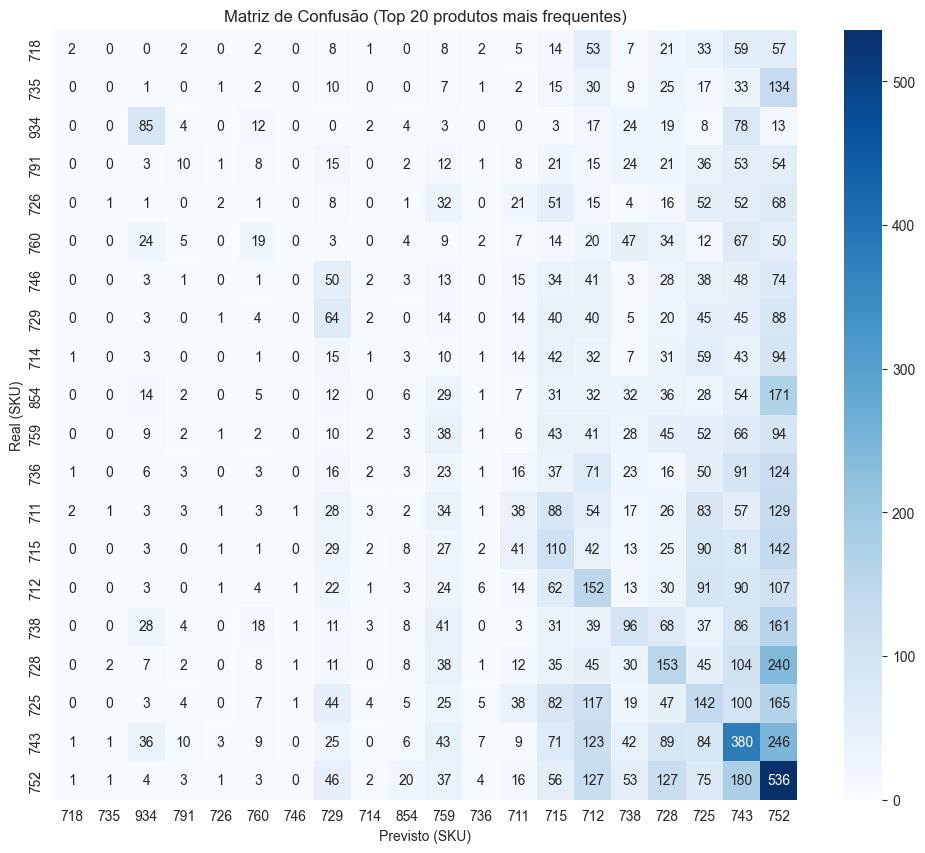

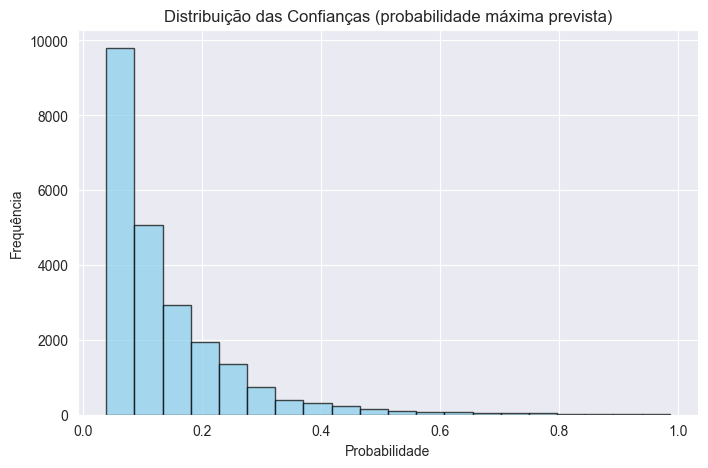


📈 Análise de Desequilíbrio de Classes:


/var/folders/n1/zpbhgwk12fv477fs6h63krsc0000gn/T/ipykernel_30400/3307884596.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SKU', y='Contagem', data=df_counts, palette="viridis", legend=False)


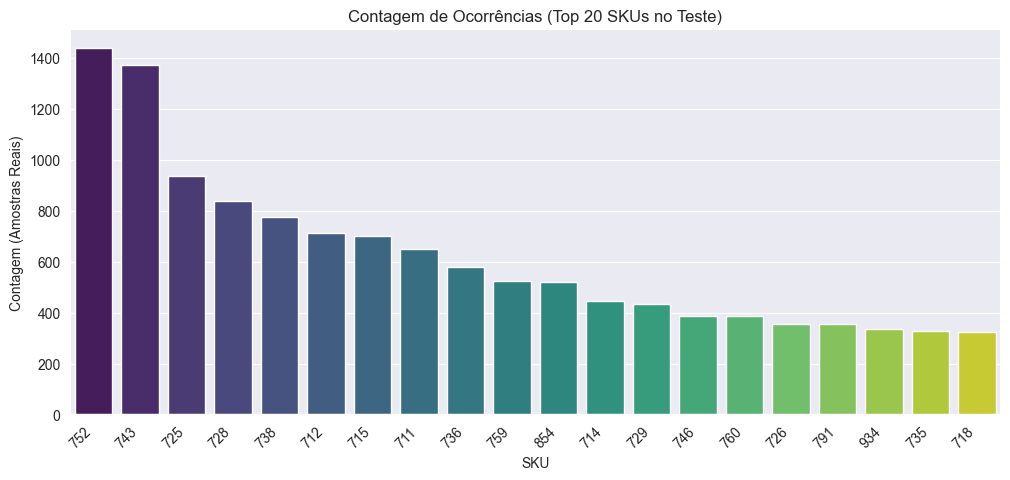


⭐ Análise Detalhada de Métricas por SKU:


/var/folders/n1/zpbhgwk12fv477fs6h63krsc0000gn/T/ipykernel_30400/3307884596.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


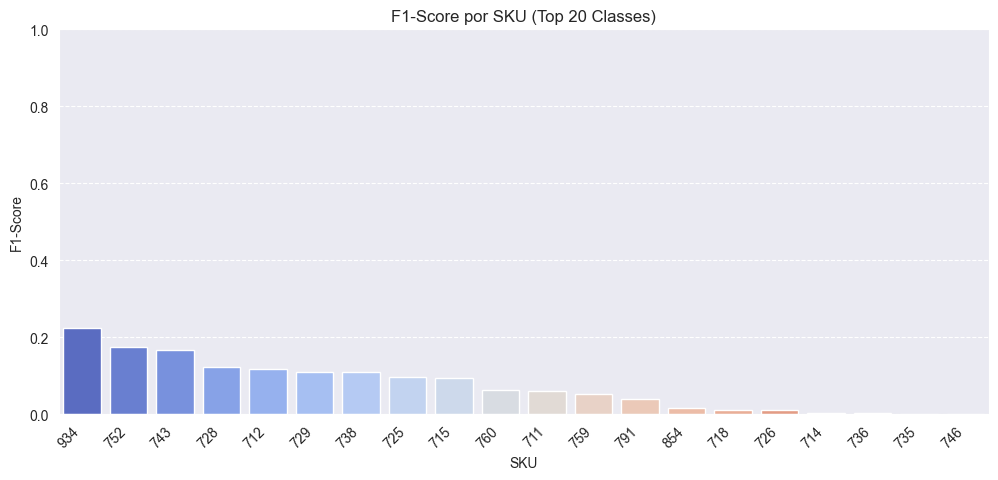

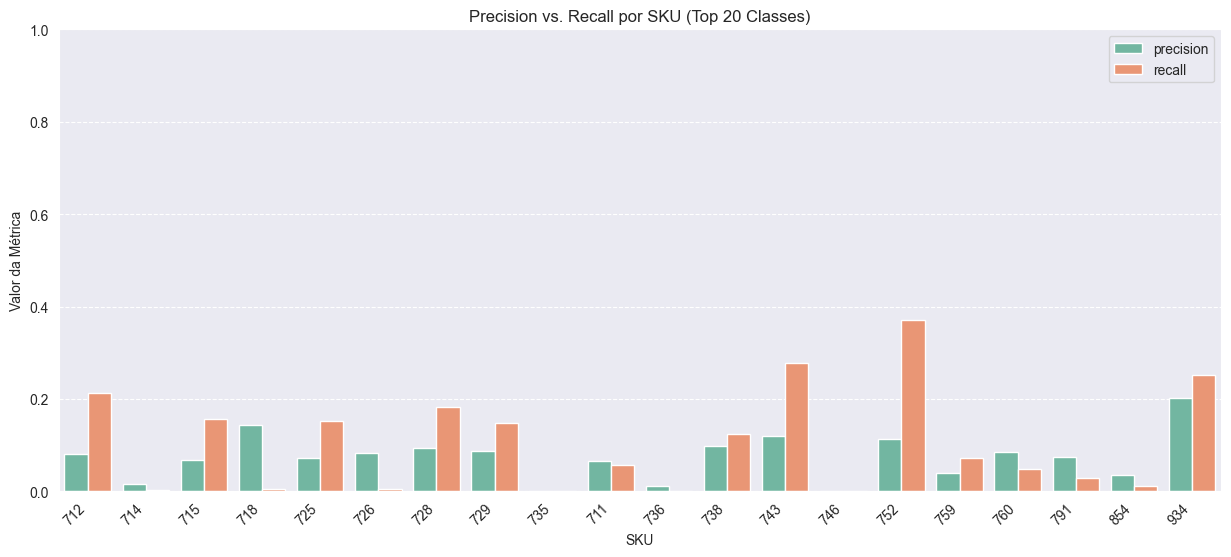

✅ Avaliação finalizada.


🏁 Script finalizado com sucesso!


In [11]:
print("🧪 Avaliando modelo no conjunto de teste...")
y_proba = model.predict(test_ds, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_proba, axis=1)
int_to_product = {v: k for k, v in product_to_int.items()}


def avaliar_classificacao(y_true, y_pred, y_proba, int_to_product, k_list=None, top_n_cm=20):
    if k_list is None:
        k_list = [1, 3, 5]
    labels, counts = np.unique(y_true, return_counts=True)
    target_names = [str(int_to_product[l]) for l in labels]
    print("\n📊 Relatório de classificação:")
    report_dict = classification_report(
        y_true, y_pred, labels=labels, target_names=target_names, zero_division=0, output_dict=True
    )
    print(classification_report(
        y_true, y_pred, labels=labels, target_names=target_names, zero_division=0
    ))
    for k in k_list:
        topk_acc = top_k_accuracy_score(
            y_true, y_proba, k=k, labels=np.arange(y_proba.shape[1])
        )
        print(f"Top-{k} Accuracy: {topk_acc:.4f}")
    # Matriz de confusão (Top N)
    top_classes = labels[np.argsort(counts)[-top_n_cm:]]
    top_target_names = [str(int_to_product[l]) for l in top_classes]
    cm = confusion_matrix(y_true, y_pred, labels=top_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=top_target_names, yticklabels=top_target_names
    )
    plt.xlabel("Previsto (SKU)")
    plt.ylabel("Real (SKU)")
    plt.title(f"Matriz de Confusão (Top {top_n_cm} produtos mais frequentes)")
    plt.show()
    # Distribuição das confianças
    plt.figure(figsize=(8, 5))
    plt.hist(np.max(y_proba, axis=1), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title("Distribuição das Confianças (probabilidade máxima prevista)")
    plt.xlabel("Probabilidade")
    plt.ylabel("Frequência")
    plt.show()
    # Contagem de classes
    print("\n📈 Análise de Desequilíbrio de Classes:")
    df_counts = pd.DataFrame({'SKU': target_names, 'Contagem': counts})
    df_counts = df_counts.sort_values(by='Contagem', ascending=False).head(top_n_cm)
    plt.figure(figsize=(12, 5))
    sns.barplot(x='SKU', y='Contagem', data=df_counts, palette="viridis", legend=False)
    plt.title(f"Contagem de Ocorrências (Top {top_n_cm} SKUs no Teste)")
    plt.xlabel("SKU")
    plt.ylabel("Contagem (Amostras Reais)")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    # Métricas por classe
    print("\n⭐ Análise Detalhada de Métricas por SKU:")
    df_metrics = pd.DataFrame(report_dict).transpose()
    df_metrics = df_metrics.iloc[:-3]
    df_metrics = df_metrics.reset_index().rename(columns={'index': 'SKU'})
    df_metrics = df_metrics[df_metrics['SKU'].isin(top_target_names)]
    plt.figure(figsize=(12, 5))
    sns.barplot(
        x='SKU',
        y='f1-score',
        data=df_metrics.sort_values(by='f1-score', ascending=False),
        palette="coolwarm",
        legend=False
    )
    plt.title(f"F1-Score por SKU (Top {top_n_cm} Classes)")
    plt.xlabel("SKU")
    plt.ylabel("F1-Score")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--')
    plt.show()
    # Precision e Recall juntos
    df_metrics_melted = df_metrics.melt(id_vars='SKU', value_vars=['precision', 'recall'], var_name='Métrica',
                                        value_name='Valor')
    plt.figure(figsize=(15, 6))
    sns.barplot(x='SKU', y='Valor', hue='Métrica', data=df_metrics_melted, palette="Set2")
    plt.title(f"Precision vs. Recall por SKU (Top {top_n_cm} Classes)")
    plt.xlabel("SKU")
    plt.ylabel("Valor da Métrica")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--')
    plt.show()


avaliar_classificacao(y_test, y_pred, y_proba, int_to_product)
print("✅ Avaliação finalizada.\n")
print("\n🏁 Script finalizado com sucesso!")